In [5]:
import os

import numpy as np
from datetime import datetime

import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot as plt

In [15]:
TRAIN_SIZE = 20
VAL_SIZE = 100
POOL_SIZE = 60_000 - (TRAIN_SIZE + VAL_SIZE)
print(f"train size: {TRAIN_SIZE:_}, val size: {VAL_SIZE:_}, pool size: {POOL_SIZE:_}")

DATA_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/data/mnist/'
MODEL_SAVE_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/models/'

SEED = 1

torch.manual_seed(SEED)
np.random.seed(SEED)

train size: 20, val size: 100, pool size: 59_880


# Data Loading

train .. size:     20, mean:  0.002, std:  1.004
val .... size:    100, mean: -0.004, std:  0.997
pool ... size: 59_880, mean:  0.000, std:  1.000
test ... size: 10_000, mean:  0.005, std:  1.008


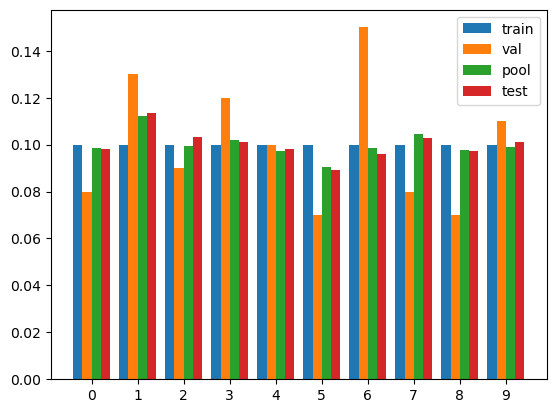

In [40]:
torch.manual_seed(SEED)
np.random.seed(SEED)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     # we do this bc the images are 28x28 but the network expects 32x32
     torchvision.transforms.Pad(2),
     # 0.10003718,  are mean and std of train set after padding (without padding it is 0.1307 and 0.3081)
     torchvision.transforms.Normalize((0.10003718,), (0.2752173,)),
     ])

# getting the test and train set
mnist_train = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=transform)

# splitting train further into train and val
train, val = torch.utils.data.random_split(mnist_train, [TRAIN_SIZE + POOL_SIZE, VAL_SIZE])

# creating data loaders
# having batch size equal to the size of the dataset to get the whole dataset in one batch
# enables us to get the whole dataset at once when iterating over the loader
train_loader = torch.utils.data.DataLoader(train, batch_size=len(train), shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True)

X_train_all, y_train_all = next(iter(train_loader))
X_val, y_val = next(iter(val_loader))
X_test, y_test = next(iter(test_loader))

# creating a random but balanced initial training set
idx = []
for num in range(10):
    indices = torch.where(y_train_all == num)[0]
    idx += list(np.random.choice(indices, 2, replace=False))
idx = torch.tensor(idx)

X_train = X_train_all[idx]
y_train = y_train_all[idx]

X_pool = X_train_all[~torch.isin(torch.arange(len(X_train_all)), idx)]
y_pool = y_train_all[~torch.isin(torch.arange(len(X_train_all)), idx)]

print(f"train .. size: {len(X_train):6_}, mean: {X_train.mean():6.3f}, std: {X_train.std():6.3f}")
print(f"val .... size: {len(X_val):6_}, mean: {X_val.mean():6.3f}, std: {X_val.std():6.3f}")
print(f"pool ... size: {len(X_pool):6_}, mean: {X_pool.mean():6.3f}, std: {X_pool.std():6.3f}")
print(f"test ... size: {len(X_test):6_}, mean: {X_test.mean():6.3f}, std: {X_test.std():6.3f}")

plt.hist([y_train, y_val, y_pool, y_test], bins=range(0, 11), density=True, label=['train', 'val', 'pool', 'test'])

# set x ticks
plt.xticks(np.linspace(0.5, 9.5, 10), np.arange(0, 10))
plt.legend()
plt.show()

val_set = torch.utils.data.TensorDataset(X_val, y_val) 
test_set = torch.utils.data.TensorDataset(X_test, y_test)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True)

# Model

In [33]:
class LeNet(nn.Module):
    
    def __init__(self):
         super(LeNet, self).__init__()
         self.conv1 = nn.Conv2d(1, 6, 5)
         self.conv2 = nn.Conv2d(6, 16, 5)
         self.pool = nn.MaxPool2d(2)
         self.do1 = nn.Dropout(0.25)  # 0.25 chosen as in Gal et al. 2016
         self.do2 = nn.Dropout(0.5)  # 0.5 chosen as in Gal et al. 2016
         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # images are 5x5 with 16 channels
         self.fc2 = nn.Linear(120, 84)
         self.fc3 = nn.Linear(84, 10)
         
    def forward(self, x):               # x.shape = (b, 32, 32), where b is batch size
        c1 = F.relu(self.conv1(x))      # c1.shape = (b, 6, 28, 28)
        p2 = self.pool(c1)              # p2.shape = (b, 6, 12, 12)
        c3 = F.relu(self.conv2(p2))     # c3.shape = (b, 16, 10, 10)
        p4 = self.pool(c3)              # p4.shape = (b, 16, 5, 5)
        p5 = torch.flatten(p4, 1)       # p5.shape = (b, 16*5*5) = (b, 400)
        d6 = self.do1(p5)               # d6.shape = (b, 400)
        f7 = F.relu(self.fc1(d6))       # f6.shape = (b, 120)
        d8 = self.do2(f7)               # d8.shape = (b, 12)
        f9 = F.relu(self.fc2(d8))       # f9.shape = (b, 84)
        output = self.fc3(f9)           # output.shape = (b, 10)
        return output

# Training and Testing Functions

In [86]:
def train_one_epoch(model,
                    optimizer,
                    loss_fn,
                    train_loader,
                    epoch_index,
                    tb_writer,
                    write_at=1000,
                    verbose=False):
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % write_at == write_at-1:
            last_loss = running_loss / write_at # loss per batch
            if verbose:
                print(f'  batch {i + 1:7_d} train loss: {last_loss:6.4f}')
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [96]:
def run_training(model,
                 train_loader,
                 val_loader,
                 optimizer,
                 loss_fn,
                 n_epochs=5,
                 verbose=False):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(f'runs/mnist_trainer_{timestamp}')
    model_path = MODEL_SAVE_PATH + str(timestamp) + '/'
    os.makedirs(model_path, exist_ok=True)
    best_vloss = np.inf
    
    for epoch in range(n_epochs):
        if verbose:
            print('EPOCH {}:'.format(epoch + 1))
    
        model.train(True)
        avg_loss = train_one_epoch(model=model,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   train_loader=train_loader,
                                   epoch_index=epoch,
                                   tb_writer=writer,
                                   write_at=5000,
                                   verbose=verbose)
    
        running_vloss = 0.0
        model.eval()
    
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, (vinputs, vlabels) in enumerate(val_loader):
                voutputs = net(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)
        if verbose:
            print(f'LOSS train {avg_loss:6.5f} valid {avg_vloss:6.4f}\n')
    
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                           {'Training': avg_loss, 'Validation': avg_vloss},
                           epoch + 1)
        writer.flush()
    
        # track the best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = model_path + f'model_{timestamp}_{epoch}'
            torch.save(net.state_dict(), model_path)
            
    if verbose:
        print('Done.')
    return model_path

In [87]:
def get_acc(model, dataloader):
    model.eval()
    running_corrects = 0
    predications = []
    
    for i, (tinputs, tlabels) in enumerate(dataloader):
        toutputs = net(tinputs)
        toutputs = torch.argmax(toutputs, dim=1)
        running_corrects += torch.sum(toutputs == tlabels.data)
        predications += toutputs.tolist()
        
    acc = running_corrects.float() / (len(dataloader) * 4)
    return acc

# Acquisition Functions

In [76]:
def perform_acquisition(model, acquisition_function, X_train, y_train, X_pool, y_pool):
    idx = acquisition_function(model, X_pool)
    
    chosen_X_pool = X_pool[idx]
    chosen_y_pool = y_pool[idx]
    
    new_X_train = torch.concatenate([X_train, chosen_X_pool], 0)
    new_y_train = torch.concatenate([y_train, chosen_y_pool], 0)
    
    new_X_pool = X_pool[~torch.isin(torch.arange(len(X_pool)), idx)]
    new_y_pool = y_pool[~torch.isin(torch.arange(len(y_pool)), idx)]
    
    return new_X_train, new_y_train, new_X_pool, new_y_pool

def random(model, X_pool, size=100):
    idx = np.random.choice(range(len(X_pool)), size=size, replace=False)
    idx = torch.from_numpy(idx)
    return idx

# Experiments

In [90]:
net = LeNet()
print(net)

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"number of trainable parameters: {params}")

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout(p=0.25, inplace=False)
  (do2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
number of trainable parameters: 61706


In [94]:
train_set = torch.utils.data.TensorDataset(
    torch.concatenate([X_train, X_pool, X_val], 0),
    torch.concatenate([y_train, y_pool, y_val], 0)
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()

In [95]:
path = run_training(net,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    n_epochs=5,
                    verbose=True)

EPOCH 1:
  batch   5_000 train loss: 0.6871
  batch  10_000 train loss: 0.2184
  batch  15_000 train loss: 0.1771
LOSS train 0.17706 valid 0.0234

Done.
EPOCH 2:
  batch   5_000 train loss: 0.1489
  batch  10_000 train loss: 0.1337
  batch  15_000 train loss: 0.1236
LOSS train 0.12356 valid 0.0495

Done.
EPOCH 3:
  batch   5_000 train loss: 0.1129
  batch  10_000 train loss: 0.1061
  batch  15_000 train loss: 0.0996
LOSS train 0.09962 valid 0.0024

Done.
EPOCH 4:
  batch   5_000 train loss: 0.1024
  batch  10_000 train loss: 0.0919
  batch  15_000 train loss: 0.0878
LOSS train 0.08776 valid 0.0152

Done.
EPOCH 5:
  batch   5_000 train loss: 0.0916
  batch  10_000 train loss: 0.0833
  batch  15_000 train loss: 0.0811
LOSS train 0.08115 valid 0.0091

Done.


In [102]:
# path = MODEL_SAVE_PATH + '20240830_181057/model_20240830_181057_0model_20240830_181057_2'
best_model = LeNet()
best_model.load_state_dict(torch.load(path, weights_only=True))
acc = get_acc(best_model, test_loader)
print(f'accuracy of best model: {acc:.4f}')

accuracy of best model: 0.9879


In [ ]:
running_X_train = X_train
running_y_train = y_train

running_X_pool = X_pool
running_y_pool = y_pool

for i in range(10):
    train_set = torch.utils.data.TensorDataset(running_X_train, running_y_train)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)